In [2]:
import jax.numpy as np
from jax import random, vmap, jit, value_and_grad, jacfwd
from jaxopt import OptaxSolver
from optax import adamw
from tqdm import trange
from NN import Siren
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True) # Enable double precision

In [1]:
# Model architecture
width = 50
layers = [2, width, width, width, 1]
w0=10.

# Optimizer and the number of steps
optimizer = adamw(1e-03)
nIter=10**5

# Plot
extent=[0,1,1,0]

In [3]:
# Define the model
class PINNs:
    def __init__(self, PINN_layers=[1,10,1], w0=10.):
        #Initialize
        self.PINN_init, self.PINN_apply = Siren(PINN_layers, w0)
        #Loggers
        self.train_log = []

    def PINN(self, params, x, t):
        input = np.stack([x, t])
        outputs = self.PINN_apply(params, input)
        return outputs.reshape(())
    
    def PINN_x(self, params, x, t):
        u_x = jacfwd(self.PINN, argnums=1)
        return u_x(params, x, t).reshape(())

    def PINN_xx(self, params, x, t):
        u_xx = jacfwd(self.PINN_x, argnums=1)
        return u_xx(params, x, t).reshape(())
    
    def PINN_t(self, params, x, t):
        u_t = jacfwd(self.PINN, argnums=2)
        return u_t(params, x, t).reshape(())

## Convection equation.

$u_t + \beta u_x = 0, \quad u(0, t) = u(2\pi, t), \ u(x,0) = \sin(x), \quad  (x,t) \in [0,2\pi] \times[0,1]$.

Here, we considered $\beta = 30$.

In [4]:
model = PINNs(PINN_layers=layers, w0=10.)
params_0 = model.PINN_init(random.PRNGKey(0))

@jit
def loss_pde(params, xt_rd=np.meshgrid(np.linspace(0,2*np.pi,100), np.linspace(0,1,100))):
    x_rd, t_rd = xt_rd
    u_t = vmap(model.PINN_t, (None,0,0))(params, x_rd.reshape(-1), t_rd.reshape(-1))
    u_x = vmap(model.PINN_x, (None,0,0))(params, x_rd.reshape(-1), t_rd.reshape(-1))
    mse = np.mean( (u_t + 30.*u_x).ravel()**2 )
    return mse

@jit
def loss_in(params, x_in=np.linspace(0,2*np.pi,100), f=np.sin):
    u0 = vmap(model.PINN, (None,0,None))(params, x_in, 0)
    f_in = f(x_in)
    mse = np.mean((u0 - f_in).ravel()**2)
    return mse

@jit
def loss_bc(params, t_bc=np.linspace(0,1,100)):
    u_left = vmap(model.PINN, (None,None,0))(params, 0., t_bc)
    u_right = vmap(model.PINN, (None,None,0))(params, 2*np.pi, t_bc)
    mse = np.mean((u_left - u_right).ravel()**2)
    return mse

@jit
def loss(params):
    return (loss_pde(params) + loss_in(params) + loss_bc(params))/3.

def train(maxiter, state, update, init_params):
    total_log, pde_log, in_log, bc_log = [], [], [], []
    pbar = trange(maxiter)
    params = init_params
    min_loss = 1e+08
    for it in pbar:
        params, state = update(params, state)
        if it%100 == 0:
            total_loss = state.value
            total_log.append(total_loss)
            pde_loss = loss_pde(params)
            pde_log.append(pde_loss)
            in_loss = loss_in(params)
            in_log.append(in_loss)
            bc_loss = loss_bc(params)
            bc_log.append(bc_loss)
            if min_loss > total_loss:
                min_loss = total_loss
                opt_params = params
        # Print losses during training
        pbar.set_postfix({'total': min_loss, 'pde':pde_loss, 'in':in_loss, 'bc':bc_loss})
    return opt_params, total_log, pde_log, in_log, bc_log

solver = OptaxSolver(fun=value_and_grad(loss), opt=optimizer, value_and_grad=True)
state = solver.init_state(params_0)
update = jit(solver.update)
opt_params, *logs = train(nIter, state, update, params_0)

100%|█| 100000/100000 [12:33<00:00, 132.79it/s, total=1.559116265007099e-07, pde=6.728261394180428e-05, in=4.89747121011845e-06, b


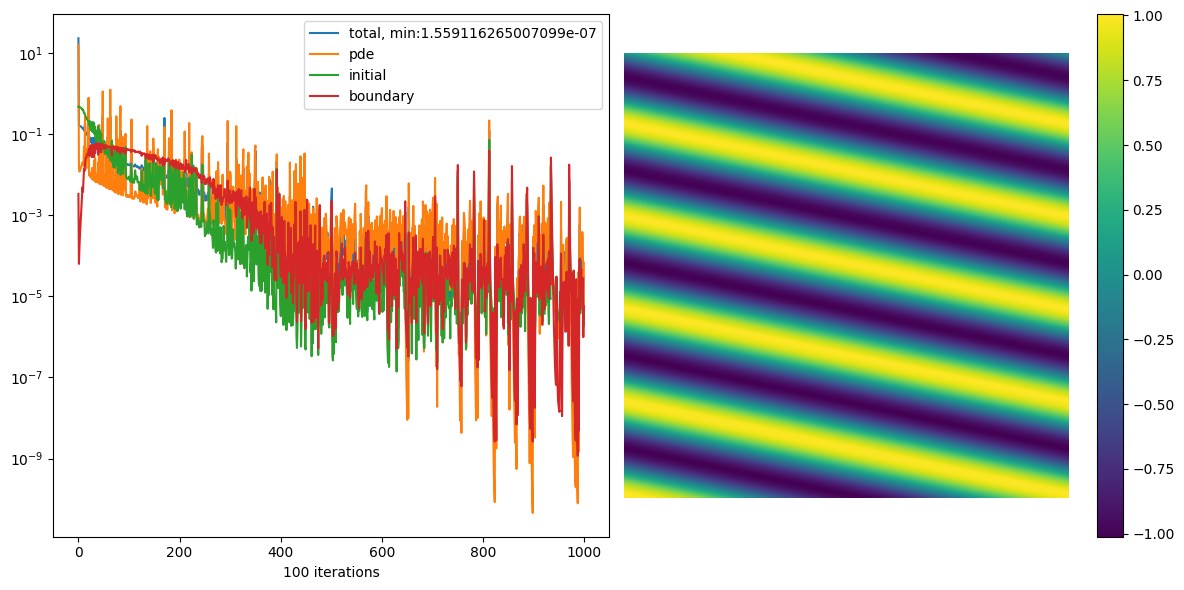

In [5]:
x, t = np.meshgrid(np.linspace(0,2*np.pi, 200), np.linspace(0,1,200))
u_pred = vmap(model.PINN, (None,0,0))(opt_params,x.reshape(-1),t.reshape(-1)).reshape(200,-1)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.semilogy(logs[0], label='total, min:'+str(min(logs[0])))
plt.semilogy(logs[1], label='pde')
plt.semilogy(logs[2], label='initial')
plt.semilogy(logs[3], label='boundary')
plt.xlabel('100 iterations')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(u_pred)
plt.axis('off')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.tight_layout()
plt.show()

## Reaction Equation.

$u_t = \rho u(1-u), \quad u(0,t) = u(2\pi, t), \ u(x, 0) = \exp\left( - \frac{(x-\pi)^2}{2(\pi/4)^2}\right), \quad (x,t) \in [0, 2\pi]\times [0, 1]$.

Here we considered $\rho = 5$.

In [6]:
model = PINNs(PINN_layers=layers, w0=10.)
params_0 = model.PINN_init(random.PRNGKey(0))

def h(x):
    exponent = (x-np.pi)/(np.pi/4)
    return np.exp(-0.5*(exponent**2))

@jit
def loss_pde(params, xt_rd=np.meshgrid(np.linspace(0,2*np.pi,100), np.linspace(0,1,100))):
    x_rd, t_rd = xt_rd
    u_t = vmap(model.PINN_t, (None,0,0))(params, x_rd.reshape(-1), t_rd.reshape(-1))
    u   = vmap(model.PINN,   (None,0,0))(params, x_rd.reshape(-1), t_rd.reshape(-1))
    mse = np.mean( (u_t - 5.* u*(1-u)).ravel()**2 )
    return mse

@jit
def loss_in(params, x_in=np.linspace(0,2*np.pi,100), f=h):
    u0 = vmap(model.PINN, (None,0,None))(params, x_in, 0)
    f_in = f(x_in)
    mse = np.mean((u0 - f_in).ravel()**2)
    return mse

@jit
def loss_bc(params, t_bc=np.linspace(0,1,100)):
    u_left = vmap(model.PINN, (None,None,0))(params, 0., t_bc)
    u_right = vmap(model.PINN, (None,None,0))(params, 2*np.pi, t_bc)
    mse = np.mean((u_left - u_right).ravel()**2)
    return mse

@jit
def loss(params):
    return (loss_pde(params) + loss_in(params) + loss_bc(params))/3.

def train(maxiter, state, update, init_params):
    total_log, pde_log, in_log, bc_log = [], [], [], []
    pbar = trange(maxiter)
    params = init_params
    min_loss = 1e+08
    for it in pbar:
        params, state = update(params, state)
        if it%100 == 0:
            total_loss = state.value
            total_log.append(total_loss)
            pde_loss = loss_pde(params)
            pde_log.append(pde_loss)
            in_loss = loss_in(params)
            in_log.append(in_loss)
            bc_loss = loss_bc(params)
            bc_log.append(bc_loss)
            if min_loss > total_loss:
                min_loss = total_loss
                opt_params = params
        # Print losses during training
        pbar.set_postfix({'total': min_loss, 'pde':pde_loss, 'in':in_loss, 'bc':bc_loss})
    return opt_params, total_log, pde_log, in_log, bc_log

solver = OptaxSolver(fun=value_and_grad(loss), opt=optimizer, value_and_grad=True)
state = solver.init_state(params_0)
update = jit(solver.update)
opt_params, *logs = train(nIter, state, update, params_0)

100%|█| 100000/100000 [10:24<00:00, 160.20it/s, total=6.470666731729937e-08, pde=3.543934050929228e-05, in=3.562288591478916e-05, 


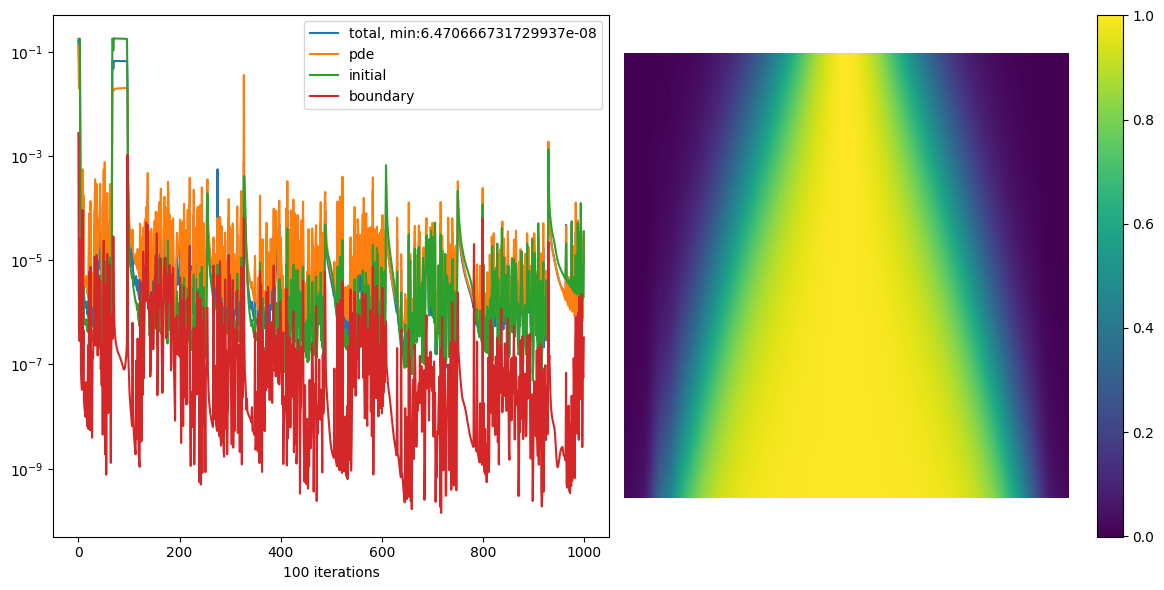

In [7]:
x, t = np.meshgrid(np.linspace(0,2*np.pi, 200), np.linspace(0,1,200))
u_pred = vmap(model.PINN, (None,0,0))(opt_params,x.reshape(-1),t.reshape(-1)).reshape(200,-1)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.semilogy(logs[0], label='total, min:'+str(min(logs[0])))
plt.semilogy(logs[1], label='pde')
plt.semilogy(logs[2], label='initial')
plt.semilogy(logs[3], label='boundary')
plt.xlabel('100 iterations')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(u_pred)
plt.axis('off')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.tight_layout()
plt.show()

## Reaction-Diffusion.

$u_t = \rho u(1-u) + \nu u_{xx}, \quad u(0,t) = u(2\pi, t), \ u(x, 0) = \exp\left( - \frac{(x-\pi)^2}{2(\pi/4)^2}\right), \quad (x,t) \in [0, 2\pi]\times [0, 1]$.

Here we considered $\rho = \nu = 5$.

In [8]:
model = PINNs(PINN_layers=layers, w0=10.)
params_0 = model.PINN_init(random.PRNGKey(0))

@jit
def loss_pde(params, xt_rd=np.meshgrid(np.linspace(0,2*np.pi,100), np.linspace(0,1,100))):
    x_rd, t_rd = xt_rd
    u_t = vmap(model.PINN_t, (None,0,0))(params, x_rd.reshape(-1), t_rd.reshape(-1))
    u_xx= vmap(model.PINN_xx,(None,0,0))(params, x_rd.reshape(-1), t_rd.reshape(-1))
    u   = vmap(model.PINN   ,(None,0,0))(params, x_rd.reshape(-1), t_rd.reshape(-1))
    mse = np.mean( (u_t -5.*u_xx - 5.*u*(1-u)).ravel()**2 )
    return mse

@jit
def loss_in(params, x_in=np.linspace(0,2*np.pi,100), f=h):
    u0 = vmap(model.PINN, (None,0,None))(params, x_in, 0)
    f_in = f(x_in)
    mse = np.mean((u0 - f_in).ravel()**2)
    return mse

@jit
def loss_bc(params, t_bc=np.linspace(0,1,100)):
    u_left = vmap(model.PINN, (None,None,0))(params, 0., t_bc)
    u_right = vmap(model.PINN, (None,None,0))(params, 2*np.pi, t_bc)
    mse = np.mean((u_left - u_right).ravel()**2)
    return mse

@jit
def loss(params):
    return (loss_pde(params) + loss_in(params) + loss_bc(params))/3.

def train(maxiter, state, update, init_params):
    total_log, pde_log, in_log, bc_log = [], [], [], []
    pbar = trange(maxiter)
    params = init_params
    min_loss = 1e+08
    for it in pbar:
        params, state = update(params, state)
        if it%100 == 0:
            total_loss = state.value
            total_log.append(total_loss)
            pde_loss = loss_pde(params)
            pde_log.append(pde_loss)
            in_loss = loss_in(params)
            in_log.append(in_loss)
            bc_loss = loss_bc(params)
            bc_log.append(bc_loss)
            if min_loss > total_loss:
                min_loss = total_loss
                opt_params = params
        # Print losses during training
        pbar.set_postfix({'total': min_loss, 'pde':pde_loss, 'in':in_loss, 'bc':bc_loss})
    return opt_params, total_log, pde_log, in_log, bc_log

solver = OptaxSolver(fun=value_and_grad(loss), opt=optimizer, value_and_grad=True)
state = solver.init_state(params_0)
update = jit(solver.update)
opt_params, *logs = train(nIter, state, update, params_0)

100%|█| 100000/100000 [19:33<00:00, 85.21it/s, total=9.369470058938024e-07, pde=2.746595692386772e-05, in=1.5248851922622116e-06, 


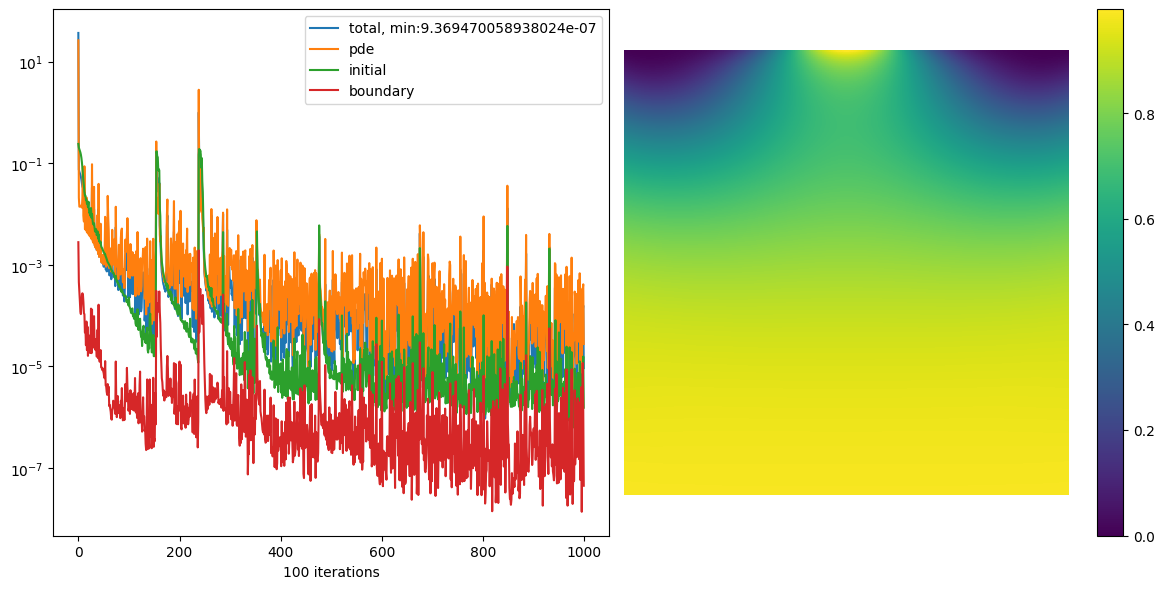

In [9]:
x, t = np.meshgrid(np.linspace(0,2*np.pi, 200), np.linspace(0,1,200))
u_pred = vmap(model.PINN, (None,0,0))(opt_params,x.reshape(-1),t.reshape(-1)).reshape(200,-1)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.semilogy(logs[0], label='total, min:'+str(min(logs[0])))
plt.semilogy(logs[1], label='pde')
plt.semilogy(logs[2], label='initial')
plt.semilogy(logs[3], label='boundary')
plt.xlabel('100 iterations')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(u_pred)
plt.axis('off')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.tight_layout()
plt.show()

## References.

1. Raissi et al. Journal of Compunational Physics, 2019, https://doi.org/10.1016/j.jcp.2018.10.045
2. Krishnapriyan et al. Neurips, 2021, https://arxiv.org/abs/2109.01050
3. Sitzmann et al. Neurips, 2020, https://arxiv.org/abs/2006.09661